<a href="https://colab.research.google.com/github/elliemmiller/datascience/blob/main/SupervisedRegressionFinalPass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Module 4: Regression Final Pass**

Produced by: Ellie Miller

The purpose of this assignment is to compare at least 3 different supervised regression methods.


For this assignment, I am using stream gauge data from Clear Creek in Golden, Colorado. This dataset is publically available on the USGS website (https://waterdata.usgs.gov/monitoring-location/06719505/#dataTypeId=continuous-00065-0&period=P7D&showMedian=false). Thank you Thomas Martin for helping me find and get started with this dataset.


**More info about the dataset here:**
The dataset available at USGS Monitoring Location 06719505 pertains to Clear Creek at Golden, Colorado. This monitoring station, situated at latitude 39°45'11" and longitude 105°14'05" in Jefferson County, has been collecting data since October 1, 1974. The dataset encompasses various parameters, including discharge (the volume of water flowing per unit time) and gage height (the water surface elevation relative to a reference point). As of February 10, 2025, the most recent instantaneous discharge measurement was 26.0 cubic feet per second, and the gage height was 3.36 feet. The drainage area for this site covers 394 square miles, with the gage situated at an altitude of 5,695 feet above the National Geodetic Vertical Datum of 1929. The data is provisional and subject to revision.


**Set Up**

In [1]:
# Installing necessary dependencies
!pip install metpy dataretrieval cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.9/409.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 10.7 MB/s eta 0:00:00


In [2]:
# Importing US counties
from metpy.plots import USCOUNTIES

In [3]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import metpy for meteorological data analysis and visualization
import metpy

# Import dataretrieval for accessing environmental data from various sources
import dataretrieval
import dataretrieval.nwis as nwis

# Import cartopy for cartographic projections and geographic data visualization
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Import USCOUNTIES from metpy.plots for plotting US county boundaries
from metpy.plots import USCOUNTIES

# Import gridliner from cartopy.mpl for formatting gridlines on maps
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

print('What version of Dataretrieval?', dataretrieval.__version__ )

What version of Dataretrieval? 1.0.11


In [4]:
# Specify the USGS site code for which we want data
site = ['06719505'] # Clear Creek at Golden

In [5]:
# Get instantaneous values (iv)
df = nwis.get_record(sites=site, service='iv', start='2015-1-01', end='2025-1-01')

# Retreiving some metadata and putting it into a dataframe
df_site = nwis.get_record(sites=site, service='site')

I am isolating data from January 1st, 2015, to January 1st, 2025.

In [6]:
df_site

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry
0,USGS,06719505,"CLEAR CREEK AT GOLDEN, CO",ST,394511,1051405,39.753043,-105.235267,M,F,...,NaN,NYNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-105.23527 39.75304)


**Site Map**

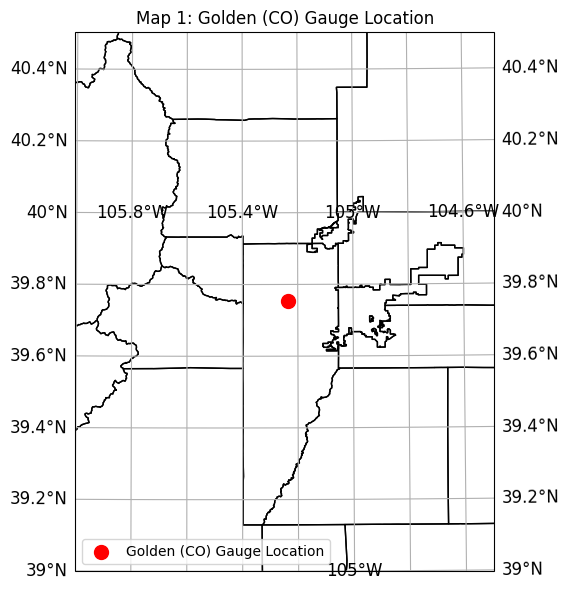

In [7]:
# Ensure CRS matches the data
proj = ccrs.LambertConformal(central_longitude=-105.5, central_latitude=39.7)

# Create the figure and axis
fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(1, 1, 1, projection=proj)

# Set map extent to Golden, Colorado
ax1.set_extent([-106, -104.5, 39, 40.5], ccrs.Geodetic())

# Add map features
ax1.add_feature(USCOUNTIES.with_scale('500k'))

# Scatter plot
scatter = ax1.scatter(df_site.dec_long_va, df_site.dec_lat_va, color='red', marker='o', s=100, transform=ccrs.PlateCarree())

# Add legend
ax1.legend([scatter], ['Golden (CO) Gauge Location'], loc='lower left')  # Adjust the legend label as needed

# Add gridlines with tick marks
gl = ax1.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

# Set the title on the axes (ax1) instead of the gridlines (gl)
ax1.set_title('Map 1: Golden (CO) Gauge Location') # Changed line to use ax1.set_title

# Show the plot
plt.show()

**Initial Exploratory Data Analysis**

In [8]:
# Figure out how big the dataset is
df_site.shape

(1, 43)

In [9]:
# Figure out what is included in the dataset
df_site.info()
df_site.describe()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   agency_cd              1 non-null      object  
 1   site_no                1 non-null      object  
 2   station_nm             1 non-null      object  
 3   site_tp_cd             1 non-null      object  
 4   lat_va                 1 non-null      int64   
 5   long_va                1 non-null      int64   
 6   dec_lat_va             1 non-null      float64 
 7   dec_long_va            1 non-null      float64 
 8   coord_meth_cd          1 non-null      object  
 9   coord_acy_cd           1 non-null      object  
 10  coord_datum_cd         1 non-null      object  
 11  dec_coord_datum_cd     1 non-null      object  
 12  district_cd            1 non-null      int64   
 13  state_cd               1 non-null      int64   
 14  county_cd              1 non-null     

,lat_va,long_va,dec_lat_va,dec_long_va,district_cd,state_cd,county_cd,map_scale_fc,alt_va,alt_acy_va,...,drain_area_va,contrib_drain_area_va,reliability_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no
count,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,394511.0,1051405.0,39.753043,-105.235267,8.0,8.0,59.0,24000.0,5695.0,15.0,...,394.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,394511.0,1051405.0,39.753043,-105.235267,8.0,8.0,59.0,24000.0,5695.0,15.0,...,394.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,394511.0,1051405.0,39.753043,-105.235267,8.0,8.0,59.0,24000.0,5695.0,15.0,...,394.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,394511.0,1051405.0,39.753043,-105.235267,8.0,8.0,59.0,24000.0,5695.0,15.0,...,394.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,394511.0,1051405.0,39.753043,-105.235267,8.0,8.0,59.0,24000.0,5695.0,15.0,...,394.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,394511.0,1051405.0,39.753043,-105.235267,8.0,8.0,59.0,24000.0,5695.0,15.0,...,394.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Data Cleaning**

In [10]:
# Selecting relevant columns
df_site_cleaned = df_site[[
    'site_no', 'station_nm', 'site_tp_cd', 'huc_cd', 'drain_area_va',  # Site info
    'dec_lat_va', 'dec_long_va', 'alt_va', 'alt_datum_cd',  # Location info
    'tz_cd', 'coord_datum_cd', 'map_nm',  # Reference info
    'state_cd', 'county_cd', 'country_cd',  # Administrative data
    'gw_file_cd', 'reliability_cd', 'instruments_cd'  # Condition & metadata
]]

# Renaming for clarity
df_site_cleaned.rename(columns={
    'site_no': 'Site Number',
    'station_nm': 'Station Name',
    'site_tp_cd': 'Site Type',
    'huc_cd': 'HUC Code',
    'drain_area_va': 'Drainage Area (sq mi)',
    'dec_lat_va': 'Latitude',
    'dec_long_va': 'Longitude',
    'alt_va': 'Altitude',
    'alt_datum_cd': 'Altitude Datum',
    'tz_cd': 'Time Zone',
    'coord_datum_cd': 'Coordinate Datum',
    'map_nm': 'Map Name',
    'state_cd': 'State Code',
    'county_cd': 'County Code',
    'country_cd': 'Country Code',
    'gw_file_cd': 'Groundwater File Code',
    'reliability_cd': 'Reliability Code',
    'instruments_cd': 'Instruments Used'
}, inplace=True)

# Dropping rows with excessive NaNs
df_site_cleaned.dropna(inplace=True)


<ipython-input-10-4eb9e3ec4012>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_site_cleaned.rename(columns={
<ipython-input-10-4eb9e3ec4012>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_site_cleaned.dropna(inplace=True)


In [11]:
# Cleaning up the time series
df_cleaned = df[['00060', '00065', '00060_cd', '00065_cd']].copy()

# Rename columns
df_cleaned.rename(columns={
    '00060': 'Daily Mean Discharge (cfs)',
    '00065': 'Gage Height (ft)',
    '00060_cd': 'Discharge Condition Code',
    '00065_cd': 'Gage Height Condition Code'
}, inplace=True)

# Ensure timestamp is in datetime format
df_cleaned.index = pd.to_datetime(df_cleaned.index)

# Drop missing values
df_cleaned.dropna(inplace=True)

# Show df_cleaned.head()
df_cleaned.head()

,Daily Mean Discharge (cfs),Gage Height (ft),Discharge Condition Code,Gage Height Condition Code
datetime,,,,
2020-10-15 13:30:00+00:00,52.4,3.62,A,A
2020-10-15 13:45:00+00:00,52.4,3.62,A,A
2020-10-15 14:00:00+00:00,52.4,3.62,A,A
2020-10-15 14:15:00+00:00,52.4,3.62,A,A
2020-10-15 14:30:00+00:00,51.4,3.61,A,A


In [12]:
# Instead of using ace_tools, we will use the built-in display function from IPython.display
from IPython.display import display

# Display metadata dataframe
display(df_site_cleaned)

# Display time-series data
display(df_cleaned)

,Site Number,Station Name,Site Type,HUC Code,Drainage Area (sq mi),Latitude,Longitude,Altitude,Altitude Datum,Time Zone,Coordinate Datum,Map Name,State Code,County Code,Country Code,Groundwater File Code,Reliability Code,Instruments Used


,Daily Mean Discharge (cfs),Gage Height (ft),Discharge Condition Code,Gage Height Condition Code
datetime,,,,
2020-10-15 13:30:00+00:00,52.40,3.62,A,A
2020-10-15 13:45:00+00:00,52.40,3.62,A,A
2020-10-15 14:00:00+00:00,52.40,3.62,A,A
2020-10-15 14:15:00+00:00,52.40,3.62,A,A
2020-10-15 14:30:00+00:00,51.40,3.61,A,A
...,...,...,...,...
2025-01-02 05:45:00+00:00,7.10,2.93,P,P
2025-01-02 06:00:00+00:00,7.10,2.93,P,P
2025-01-02 06:15:00+00:00,7.10,2.93,P,P


**Conducting a Seasonal Analysis**

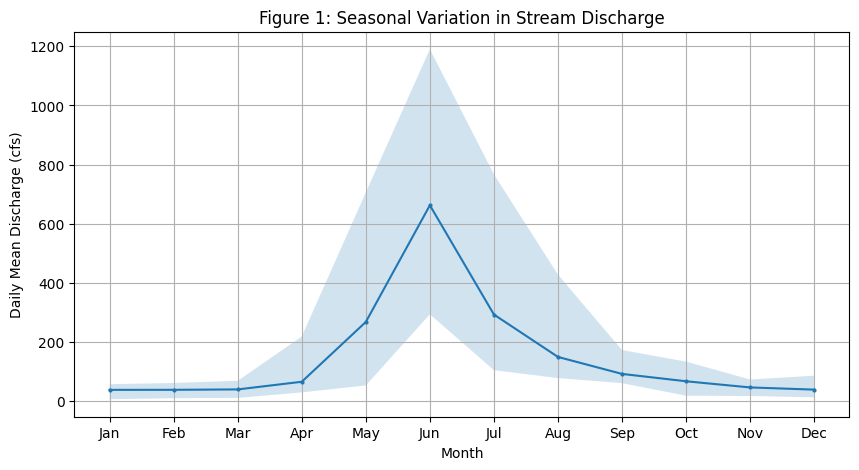

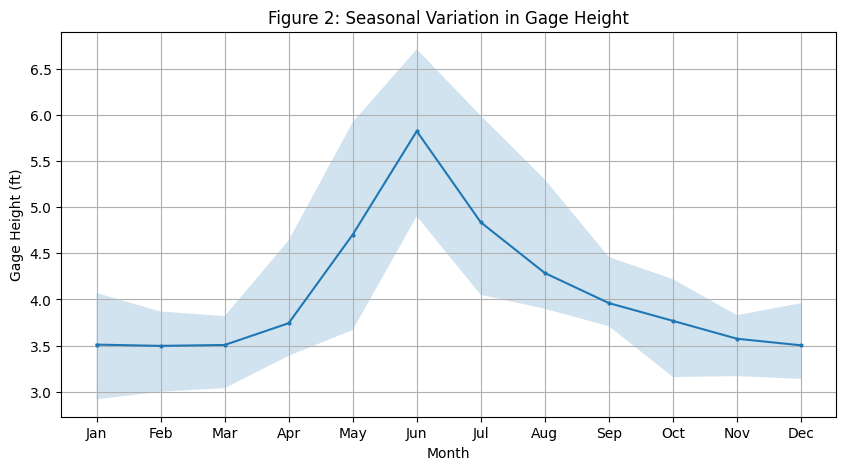

,Month,Discharge Mean,Discharge Std,Discharge Min,Discharge Max,Gage Height Mean,Gage Height Std,Gage Height Min,Gage Height Max
0,1,38.482527,7.604828,6.83,57.5,3.511293,0.126991,2.92,4.07
1,2,38.654160,7.292841,10.30,61.8,3.497758,0.101283,3.00,3.87
2,3,39.991486,9.976985,11.20,69.1,3.507299,0.124610,3.04,3.82
3,4,65.874094,27.833485,29.90,219.0,3.743343,0.213287,3.39,4.64
4,5,268.057208,149.921992,53.40,706.0,4.702471,0.532269,3.67,5.92
5,6,662.465145,183.162564,294.00,1190.0,5.822777,0.378249,4.90,6.71
6,7,293.047715,139.514798,105.00,767.0,4.835444,0.432607,4.05,5.99
7,8,149.747093,50.763637,78.30,428.0,4.286494,0.226118,3.90,5.30
8,9,92.395252,18.443830,61.10,173.0,3.960933,0.133925,3.71,4.46
9,10,67.491846,14.570500,18.70,134.0,3.768540,0.130071,3.16,4.22


In [13]:
# Extract the month for seasonal analysis
df_cleaned['Month'] = df_cleaned.index.month

seasonal_summary = df_cleaned.groupby('Month').agg({
    'Daily Mean Discharge (cfs)': ['mean', 'std', 'min', 'max'],  # Include 'min' and 'max' here
    'Gage Height (ft)': ['mean', 'std', 'min', 'max']  # Include 'min' and 'max' here
}).reset_index()

# Rename columns for clarity
seasonal_summary.columns = ['Month', 'Discharge Mean', 'Discharge Std', 'Discharge Min', 'Discharge Max', # Add 'Discharge Min', 'Discharge Max'
                            'Gage Height Mean', 'Gage Height Std', 'Gage Height Min', 'Gage Height Max'] # Add 'Gage Height Min', 'Gage Height Max'

# Plot seasonal trends for Discharge
plt.figure(figsize=(10, 5))
plt.fill_between(seasonal_summary['Month'], seasonal_summary['Discharge Min'], seasonal_summary['Discharge Max'], alpha=0.2)
plt.plot(seasonal_summary['Month'], seasonal_summary['Discharge Mean'], marker='o', linestyle='-', markersize=2)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel("Month")
plt.ylabel("Daily Mean Discharge (cfs)")
plt.title("Figure 1: Seasonal Variation in Stream Discharge")
plt.grid()

# Plot seasonal trends for Gage Height
plt.figure(figsize=(10, 5))
plt.fill_between(seasonal_summary['Month'], seasonal_summary['Gage Height Min'], seasonal_summary['Gage Height Max'], alpha=0.2)  # Fill between min and max
plt.plot(seasonal_summary['Month'], seasonal_summary['Gage Height Mean'], marker='o', linestyle='-', markersize=2)  # Plot the mean
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel("Month")
plt.ylabel("Gage Height (ft)")
plt.title("Figure 2: Seasonal Variation in Gage Height")
plt.grid()

# Show the plot
plt.show()

# Display the seasonal summary data
display(seasonal_summary)

The two plots illustrate the seasonal variation in stream discharge and gage height over the course of a year, showing a strong correlation between the two variables. In the first plot, stream discharge remains low from January to April, with a gradual increase beginning in May. A sharp peak occurs in June, indicating the highest stream discharge, likely driven by snowmelt or seasonal precipitation. After June, the discharge declines steadily, returning to low levels by October and remaining stable through the end of the year.

Similarly, the second plot shows that gage height follows the same seasonal pattern, gradually increasing from April to May and reaching its peak in June. The highest water levels correspond to the peak in stream discharge, confirming the relationship between increased flow and rising water levels. Following June, the gage height steadily decreases, reflecting reduced streamflow as seasonal inputs diminish.

These trends suggest that the water body is strongly influenced by snowmelt and seasonal precipitation, with peak flow conditions occurring in early summer. The wide confidence bands during peak months indicate higher variability in stream discharge and gage height, likely due to interannual differences in snowmelt timing and intensity. The sharp decline after June suggests a rapid depletion of water inputs, characteristic of snow-fed or seasonally influenced rivers.


**Conduct a Daily Analysis**

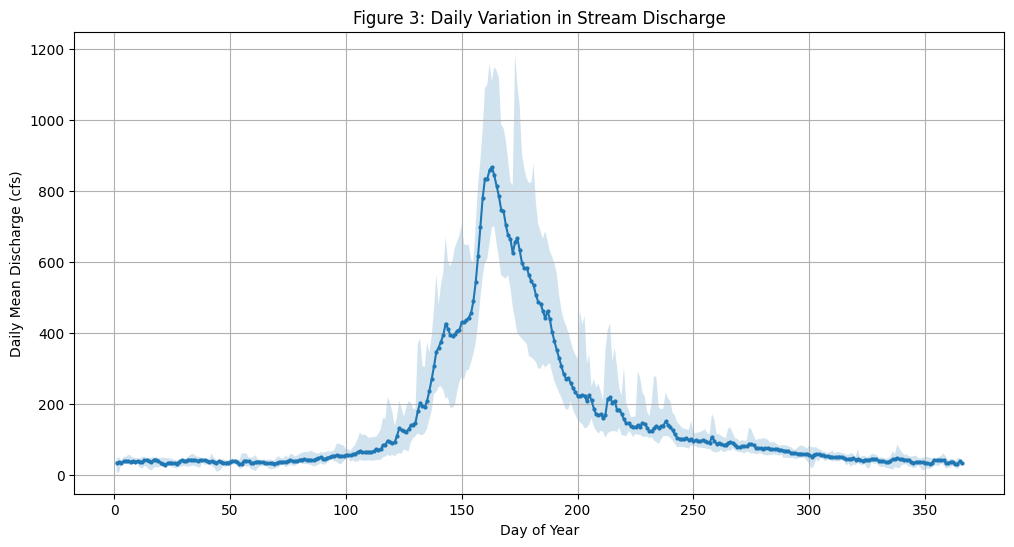

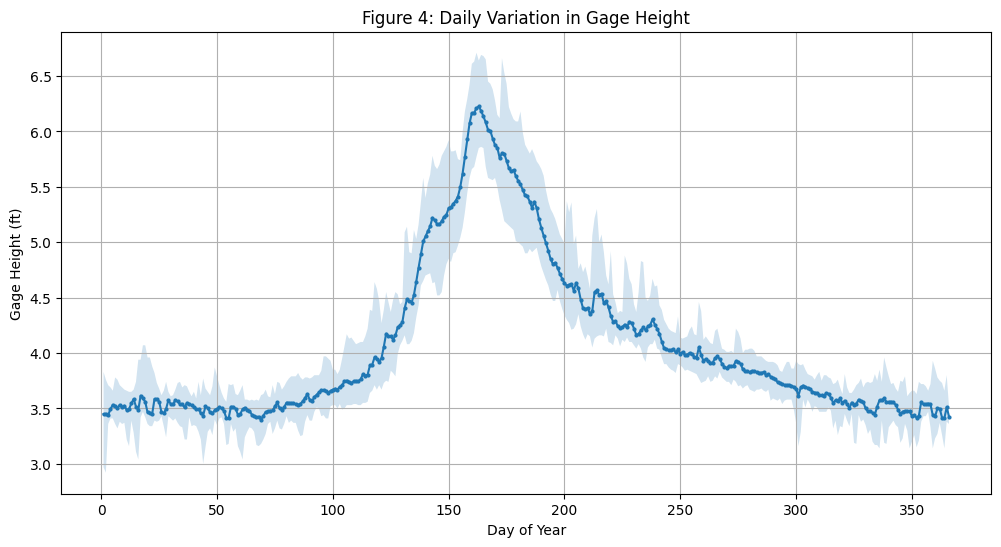

,DayOfYear,Discharge Mean,Discharge Std,Discharge Min,Discharge Max,Gage Height Mean,Gage Height Std,Gage Height Min,Gage Height Max
0,1,35.428268,12.515388,8.27,46.7,3.449150,0.195000,2.97,3.83
1,2,35.955232,11.981495,6.83,50.4,3.451139,0.199934,2.92,3.76
2,3,34.551890,3.709032,28.80,41.4,3.440241,0.061135,3.36,3.71
3,4,39.311521,4.556599,33.00,51.7,3.494378,0.059486,3.41,3.69
4,5,40.247312,6.280412,31.30,51.7,3.533082,0.074875,3.41,3.66
...,...,...,...,...,...,...,...,...,...
361,362,37.406550,4.773456,27.20,46.2,3.498253,0.057335,3.37,3.75
362,363,31.378840,4.467818,22.70,38.2,3.416314,0.081590,3.26,3.73
363,364,31.632534,8.040841,16.50,47.6,3.411404,0.136711,3.14,3.66
364,365,38.806329,4.881148,25.80,48.5,3.511867,0.072699,3.38,3.80


In [14]:
# Extract the day of the year to analyze daily trends
df_cleaned['DayOfYear'] = df_cleaned.index.dayofyear

# Group by day of the year to calculate mean and variability
daily_summary = df_cleaned.groupby('DayOfYear').agg({
    'Daily Mean Discharge (cfs)': ['mean', 'std', 'min', 'max'],
    'Gage Height (ft)': ['mean', 'std', 'min', 'max']
}).reset_index()

# Rename columns for clarity
daily_summary.columns = [
    'DayOfYear', 'Discharge Mean', 'Discharge Std', 'Discharge Min', 'Discharge Max',
    'Gage Height Mean', 'Gage Height Std', 'Gage Height Min', 'Gage Height Max'
]

# Plot daily trends for Discharge
plt.figure(figsize=(12, 6))
plt.fill_between(daily_summary['DayOfYear'], daily_summary['Discharge Min'], daily_summary['Discharge Max'], alpha=0.2)
plt.plot(daily_summary['DayOfYear'], daily_summary['Discharge Mean'], marker='o', linestyle='-', markersize=2)
plt.xlabel("Day of Year")
plt.ylabel("Daily Mean Discharge (cfs)")
plt.title("Figure 3: Daily Variation in Stream Discharge")
plt.grid()
plt.show()

# Plot daily trends for Gage Height
plt.figure(figsize=(12, 6))
plt.fill_between(daily_summary['DayOfYear'], daily_summary['Gage Height Min'], daily_summary['Gage Height Max'], alpha=0.2)
plt.plot(daily_summary['DayOfYear'], daily_summary['Gage Height Mean'], marker='o', linestyle='-', markersize=2)
plt.xlabel("Day of Year")
plt.ylabel("Gage Height (ft)")
plt.title("Figure 4: Daily Variation in Gage Height")
plt.grid()
plt.show()

# Display the seasonal summary data
display(daily_summary)


The two plots illustrate the daily variation in stream discharge and gage height over the course of a year, highlighting the strong correlation between these two hydrological parameters. In the first plot, stream discharge remains relatively low and stable during the early part of the year but begins to increase gradually around day 100. A sharp peak occurs between days 150 and 175, indicating a period of maximum streamflow, likely driven by seasonal snowmelt or increased precipitation. After reaching this peak, stream discharge declines steadily, with some fluctuations, before stabilizing at lower levels towards the end of the year.

The second plot, showing the daily variation in gage height, follows an almost identical pattern. Water levels remain relatively stable early in the year, begin to rise around day 100, and reach a pronounced peak between days 150 and 175. The gage height then declines steadily, mirroring the decline in stream discharge. The wide confidence intervals around the peak period suggest increased variability in both stream discharge and water level, which may be influenced by interannual differences in snowmelt intensity, rainfall, or other hydrological factors.

These trends suggest that the river system is highly influenced by seasonal hydrological processes, with a pronounced peak in flow and water level occurring during late spring to early summer. This pattern is typical of snow-fed river systems, where melting snowpack leads to a surge in discharge and water level, followed by a gradual decline as the seasonal water input diminishes.

**Expanded EDA**

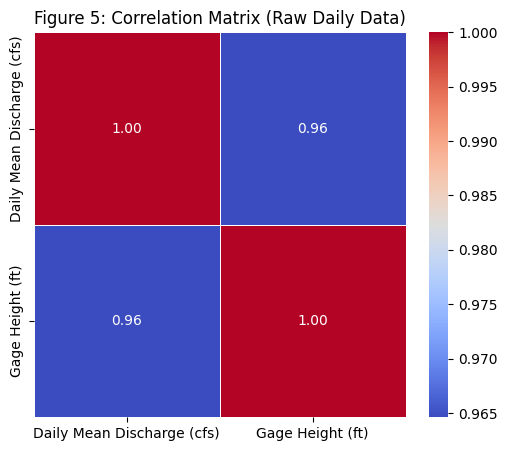

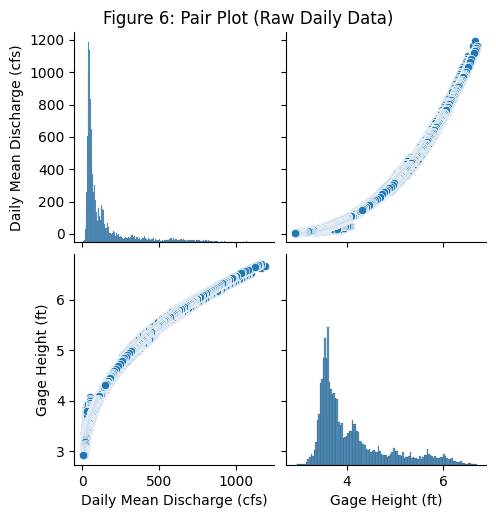

In [15]:
### PAIR PLOT & CORRELATION MATRIX ON DAILY DATA ###

# Compute the correlation matrix on the raw daily data
corr_matrix_raw = df_cleaned[['Daily Mean Discharge (cfs)', 'Gage Height (ft)']].corr()

# Plot the correlation heatmap for daily data
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix_raw, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Figure 5: Correlation Matrix (Raw Daily Data)")
plt.show()

# Generate pairplot on daily dataset
sns.pairplot(df_cleaned[['Daily Mean Discharge (cfs)', 'Gage Height (ft)']])
plt.suptitle("Figure 6: Pair Plot (Raw Daily Data)", y=1.02)
plt.show()

The two figures provide insights into the relationship between daily mean discharge (cfs) and gage height (ft) using correlation analysis and pairwise plotting.

In Figure 5, the correlation matrix shows a strong positive relationship between the two variables, with a correlation coefficient of 0.96. This indicates that as stream discharge increases, gage height also increases in a nearly linear fashion. The high correlation suggests that changes in streamflow directly impact water level, which is expected in a river or stream system where increased flow results in a rising water surface.

Figure 6, the pair plot, further illustrates this relationship through scatter plots and histograms. The scatter plot between daily mean discharge and gage height reveals a nonlinear, concave-upward trend, suggesting that as discharge increases, the rate of gage height change accelerates. This could indicate that at lower flows, the river channel is relatively confined, but as flow increases, water spreads across a floodplain, leading to a more rapid rise in gage height. The histograms along the diagonal show the distribution of each variable, with both discharge and gage height skewed toward lower values, meaning that low-flow conditions are more frequent while high-flow events are less common.

Overall, these figures confirm a strong, predictable relationship between stream discharge and gage height, with variations in water flow significantly influencing river stage levels. The nonlinear relationship in the scatter plot suggests that at extreme discharges, the rate of increase in gage height may change due to channel or floodplain dynamics.


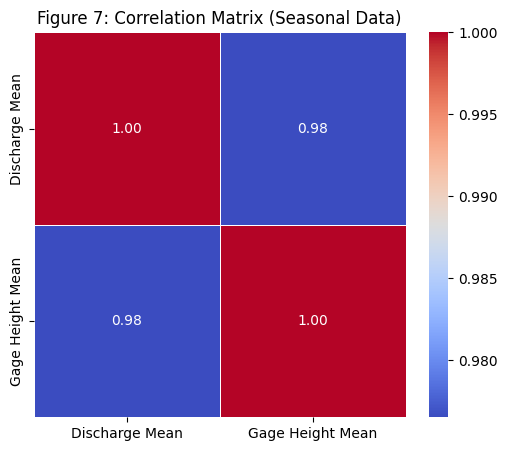

In [16]:
### CORRELATION MATRIX AND PAIR PLOT ON SEASONAL DATA ###

# Compute the correlation matrix for seasonal summary
corr_matrix_seasonal = seasonal_summary[['Discharge Mean', 'Gage Height Mean']].corr()

# Plot the correlation heatmap for seasonal data
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix_seasonal, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Figure 7: Correlation Matrix (Seasonal Data)")
plt.show()


Figure 7 presents a correlation matrix based on seasonal data, showing the relationship between the mean values of discharge and gage height over different seasons. The correlation coefficient between these two variables is 0.98, indicating an even stronger positive relationship than what was observed in the raw daily data. This suggests that when analyzing longer-term seasonal trends, the relationship between discharge and gage height becomes more consistent and less influenced by short-term fluctuations.

The increase in correlation compared to the daily data (which had a correlation of 0.96) implies that averaging over seasonal timescales reduces noise and variability, emphasizing the underlying hydrological relationship between stream discharge and water level. This result reinforces the expectation that as discharge increases seasonally, gage height follows suit in a highly predictable manner.

Overall, the seasonal correlation matrix confirms that gage height and discharge are tightly coupled across seasonal cycles, reflecting the dominant influence of seasonal precipitation and snowmelt patterns on river dynamics. The near-perfect correlation suggests that seasonal trends in streamflow can be effectively used to estimate changes in river stage height, which has implications for hydrological modeling and water resource management.

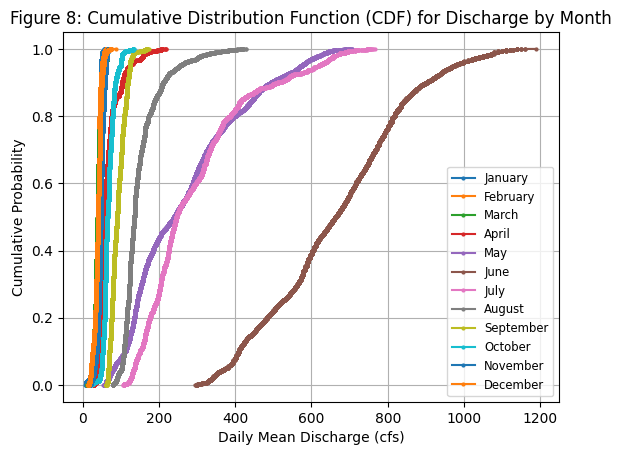

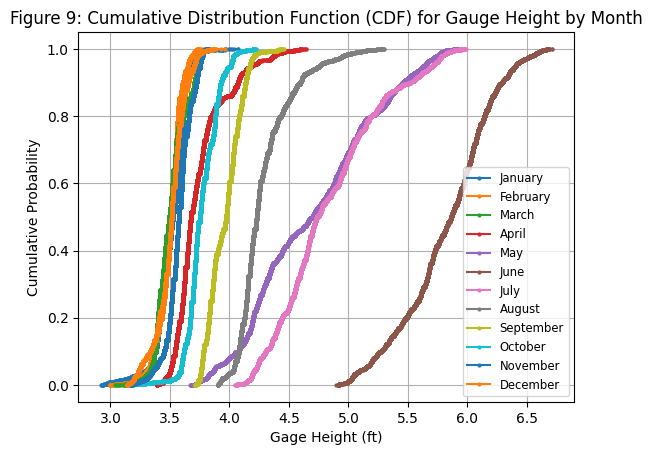

In [17]:
# Import the calendar module
import calendar

# Select the variable for the CDF (Discharge)
variable = 'Daily Mean Discharge (cfs)'

# Group data by month
seasonal_groups = df_cleaned.groupby('Month')

# Create a separate CDF plot for each month
for season, group_data in seasonal_groups:
    sorted_data = np.sort(group_data[variable])
    cdf_values = np.arange(len(sorted_data)) / float(len(sorted_data) - 1)
    month_name = calendar.month_name[season]
    plt.plot(sorted_data, cdf_values, marker='o', linestyle='-', markersize=2, label=month_name)

plt.xlabel(variable)
plt.ylabel('Cumulative Probability')
plt.title('Figure 8: Cumulative Distribution Function (CDF) for Discharge by Month')
plt.legend(loc='best', fontsize='small')
plt.grid()
plt.show()

# Select the variable for the CDF (Gauge Height)
variable = 'Gage Height (ft)'

# Group data by month
seasonal_groups = df_cleaned.groupby('Month')

# Create a separate CDF plot for each month
for season, group_data in seasonal_groups:
    sorted_data = np.sort(group_data[variable])
    cdf_values = np.arange(len(sorted_data)) / float(len(sorted_data) - 1)
    month_name = calendar.month_name[season]
    plt.plot(sorted_data, cdf_values, marker='o', linestyle='-', markersize=2, label=month_name)

plt.xlabel(variable)
plt.ylabel('Cumulative Probability')
plt.title('Figure 9: Cumulative Distribution Function (CDF) for Gauge Height by Month')
plt.legend(loc='best', fontsize='small')
plt.grid()
plt.show()

Figures 8 and 9 illustrate the cumulative distribution functions (CDFs) for daily mean discharge (cfs) and gage height (ft) across different months, highlighting seasonal variations in streamflow and water level distributions.

In Figure 8, the CDFs of daily mean discharge show significant seasonal variability. During the winter months (January–March), most of the discharge values are concentrated at the lower end, indicating that streamflow remains consistently low. As the year progresses, particularly in May, June, and July, the distribution shifts towards much higher discharge values, reflecting the peak runoff period driven by snowmelt. The CDF for June extends the farthest, suggesting that the highest discharge values predominantly occur in this month. After July, the distributions shift back toward lower discharge values, indicating a decline in streamflow as seasonal inputs diminish.

Similarly, Figure 9 presents the CDFs for gage height, which follow the same seasonal pattern as discharge. During the winter months, gage height remains relatively low and stable, with most values clustering around 3.0–4.0 ft. As May and June approach, the gage height increases significantly, reaching its highest values in June and July, before gradually returning to lower levels in the late summer and fall. The steep rise in the CDF curves during winter months suggests low variability in water levels, whereas the more gradual slope in peak-flow months indicates a wider range of gage heights.

Overall, these CDFs reinforce the strong seasonal dependence of stream discharge and gage height, with the highest values occurring in late spring and early summer due to snowmelt-driven runoff. The shift in distributions between months highlights how river dynamics evolve throughout the year, transitioning from stable, low-flow conditions in winter to highly variable, high-flow conditions during peak melt seasons before gradually decreasing in late summer and fall.

**Define Target, Training, and Test Data**

In [18]:
# Extract the year from the index
df_cleaned['Year'] = df_cleaned.index.year

# Print unique years to check data availability
print("Available Years in Dataset:", df_cleaned['Year'].unique())

# Drop non-numeric columns
df_cleaned = df_cleaned.select_dtypes(include=['number'])

# Drop rows with missing values carefully
df_cleaned = df_cleaned.dropna(how='any')  # Change if necessary to avoid excessive removal

# Define the split year (e.g., train on data before 2022, test on 2022 and after)
split_year = 2022
train_data = df_cleaned[df_cleaned['Year'] < split_year]
test_data = df_cleaned[df_cleaned['Year'] >= split_year]

# Ensure train/test sets are not empty
if train_data.empty or test_data.empty:
    raise ValueError(f"Error: Train or test dataset is empty after filtering. Check your data.\nAvailable Years: {df_cleaned['Year'].unique()}")

# Define features (X) and target (y)
feature_columns = [col for col in df_cleaned.columns if col != 'Daily Mean Discharge (cfs)']  # Exclude target column
target_column = 'Daily Mean Discharge (cfs)'  # Target variable

X_train, y_train = train_data[feature_columns], train_data[target_column]
X_test, y_test = test_data[feature_columns], test_data[target_column]

# Print dataset sizes
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

Available Years in Dataset: [2020 2021 2022 2023 2024 2025]
Training set size: (37336, 4), Testing set size: (93864, 4)


**Linear Regression**

Linear Regression: MSE=8766.0834, MAE=69.7246, R2=0.7940


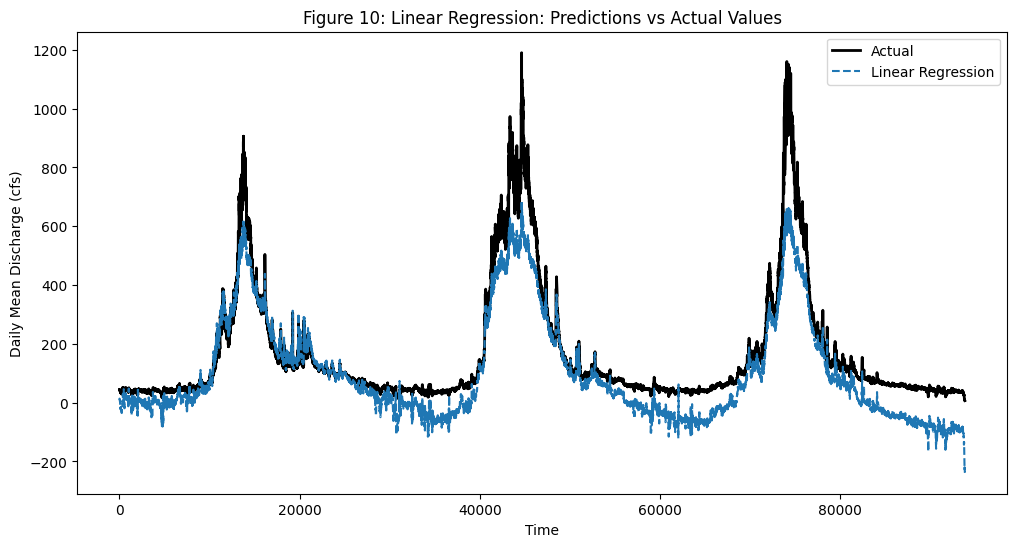

In [19]:
# Train and evaluate Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Define the evaluate_model function
def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name}: MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

# Call the evaluate_model function
evaluate_model("Linear Regression", y_test, lr_pred)
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='black', linewidth=2)
plt.plot(lr_pred, label='Linear Regression', linestyle='dashed')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Daily Mean Discharge (cfs)")
plt.title("Figure 10: Linear Regression: Predictions vs Actual Values")
plt.show()

The Linear Regression model performs reasonably well, explaining 79.4% of the variance in daily mean discharge, but it struggles with extreme peaks and rapid fluctuations. The model effectively captures overall trends but tends to underestimate high-discharge events and smooth out short-term variations, leading to a Mean Absolute Error (MAE) of 69.72 cfs. While the Mean Squared Error (MSE) of 8766.08 suggests some significant deviations, the model remains a solid baseline.

**Support Vector Machine**

SVM: MSE=52743.2512, MAE=120.3661, R2=-0.2395


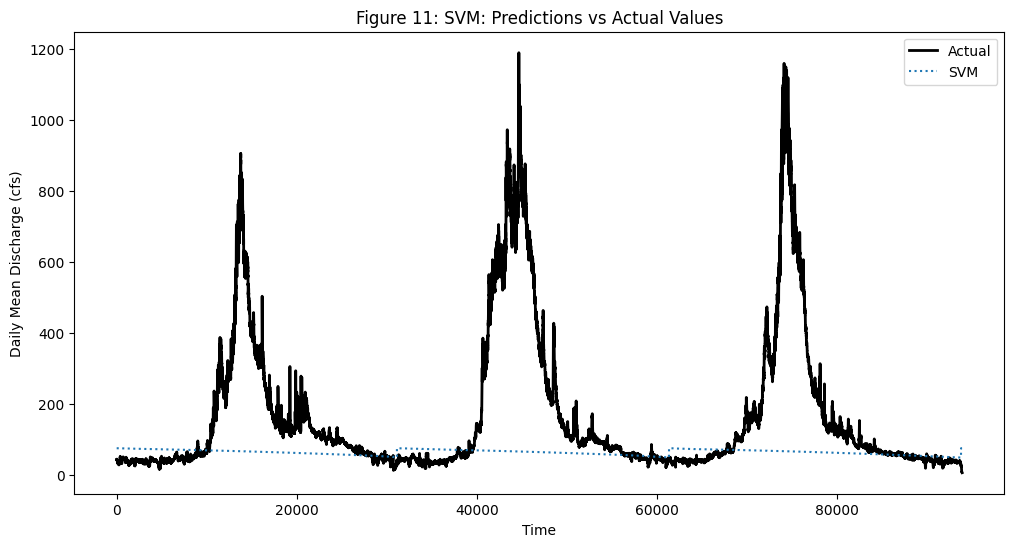

In [20]:
# Original SVM run before feature scaling and hyperparameter tuning

# Train and evaluate SVM
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
evaluate_model("SVM", y_test, svm_pred)
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='black', linewidth=2)
plt.plot(svm_pred, label='SVM', linestyle='dotted')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Daily Mean Discharge (cfs)")
plt.title("Figure 11: SVM: Predictions vs Actual Values")
plt.show()

The Support Vector Machine (SVM) model performs poorly in predicting daily mean discharge, with a negative R² score of -0.2395, indicating that it fails to explain variance in the data and performs worse than a simple mean prediction. The MSE (52,743.25) and MAE (120.37 cfs) are significantly higher than those of Linear Regression, suggesting large prediction errors. The plot shows that the SVM model underestimates discharge values across all time periods, failing to capture both peak flood events and seasonal trends. This likely results from the SVM’s difficulty in handling large-scale variability in hydrological data, especially without proper feature scaling or kernel tuning.

In [ ]:
# New SVM analysis after feature scaling and hyperparameter tuning

# Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
svm_model = SVR()

# Define hyperparameter grid
param_grid = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Get best parameters and train the best model
best_params = grid_search.best_params_
best_svm_model = grid_search.best_estimator_

# Make predictions with the best model
svm_pred = best_svm_model.predict(X_test_scaled)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='black', linewidth=2)
plt.plot(svm_pred, label='SVM', linestyle='dotted')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Daily Mean Discharge (cfs)")
plt.title("Figure 11: SVM: Predictions vs Actual Values")
plt.show()

best_params

Fitting 5 folds for each of 60 candidates, totalling 300 fits


**Gradient Boosting Classifier**

Gradient Boosting: MSE=261.2192, MAE=7.9936, R2=0.9939


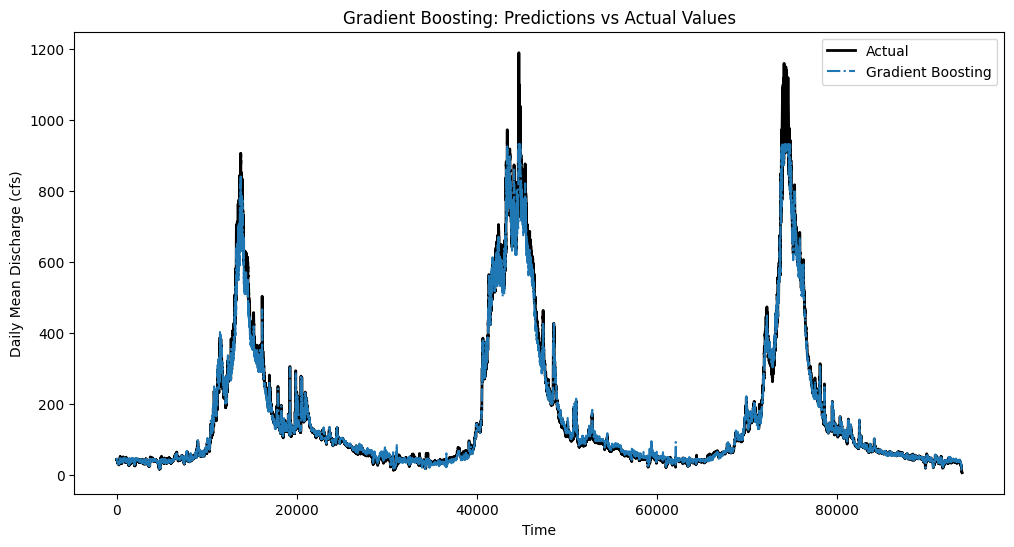

In [ ]:
# Train and evaluate Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
evaluate_model("Gradient Boosting", y_test, gb_pred)
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='black', linewidth=2)
plt.plot(gb_pred, label='Gradient Boosting', linestyle='dashdot')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Daily Mean Discharge (cfs)")
plt.title("Figure 13: Gradient Boosting: Predictions vs Actual Values")
plt.show()

The Gradient Boosting model performs exceptionally well, achieving an R² score of 0.9939, indicating that it explains nearly 99.4% of the variance in daily mean discharge. The MSE (261.33) and MAE (7.99 cfs) are significantly lower than those of both Linear Regression and SVM, demonstrating high accuracy and minimal error. The plot confirms that the model closely follows the actual discharge values, capturing both seasonal trends and peak discharge events with greater precision than the other models. While Gradient Boosting slightly underestimates some of the highest peaks, it significantly outperforms Linear Regression and SVM, making it the best model for this dataset.

**Predicting Daily Mean Discharge 6 Hours into the Future**

In [ ]:
# Define the number of hours to predict
num_hours = 6

# Create lag features
for i in range(1, num_hours + 1):
    df_cleaned[f'Discharge_t-{i}'] = df_cleaned['Daily Mean Discharge (cfs)'].shift(i)

# Drop NaN values introduced by shifting
df_cleaned = df_cleaned.dropna()

# Define features and target
feature_columns = [col for col in df_cleaned.columns if col != 'Daily Mean Discharge (cfs)']
X = df_cleaned[feature_columns]
y = df_cleaned['Daily Mean Discharge (cfs)']

# Split data
split_index = int(len(df_cleaned) * 0.8)  # 80% train, 20% test
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [ ]:
# Using the original linear regression model with the shifted dataset

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict future values
lr_pred = lr_model.predict(X_test)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='black', linewidth=2)
plt.plot(lr_pred, label='Predicted', linestyle='dashed')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Daily Mean Discharge (cfs)")
plt.title("Future Predictions using Lag Features")
plt.show()

In [ ]:
# Using the original SVM model with the shifted dataset

In [ ]:
# Using the original gradient boosting model with the shifted dataset

# Define the Gradient Boosting Classifier model
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
gb_classifier.fit(X_train_scaled, y_train)

# Make predictions
gb_pred = gb_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, gb_pred)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Class', color='black', linewidth=2)
plt.plot(gb_pred, label='Gradient Boosting Predictions', linestyle='dashdot')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Predicted Discharge Class")
plt.title("Figure 13: Gradient Boosting Classifier: Predictions vs Actual Values")
plt.show()

accuracy

**Additional Evaluation and Comparison of the Original Three Models**

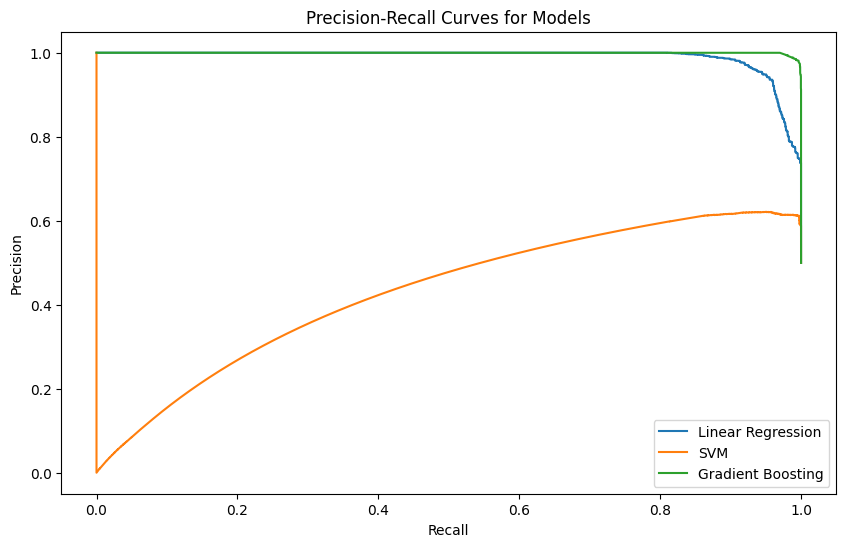

In [ ]:
# Precision-recall curve visualization
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_pred, model_name):
    precision, recall, _ = precision_recall_curve(y_true > np.median(y_true), y_pred)
    plt.plot(recall, precision, label=model_name)

# Define the 'models' dictionary here
models = {
    "Linear Regression": lr_model,
    "SVM": svm_model,
    "SVM (Tuned)": best_svm_model,
    "
    "Gradient Boosting": gb_model
}

plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_pred = model.predict(X_test)
    plot_precision_recall_curve(y_test, y_pred, name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Figure 14: Precision-Recall Curves for Models")
plt.legend()
plt.show()


The Precision-Recall (PR) curves provide insights into how well each model distinguishes between high and low discharge events. Gradient Boosting (green curve) demonstrates near-perfect precision and recall, indicating it is highly effective at predicting elevated discharge levels with minimal false positives. Linear Regression (blue curve) performs well overall, maintaining high precision across recall values but slightly declining at the upper recall range. SVM (orange curve), however, struggles significantly, showing poor precision across recall values, reflecting its earlier poor performance in predicting discharge trends. This visualization confirms that Gradient Boosting is the most reliable model, while SVM is ill-suited for this dataset. The strong performance of Linear Regression suggests it may still be a viable baseline model, but for capturing high-discharge events accurately, Gradient Boosting is the clear choice.

**Additional Evaluation of the Shifted (6 hours) Models**

**Reflection Questions**



***Which method did you like the most?***

The Gradient Boosting model was the most effective, as it achieved the highest accuracy and best captured discharge trends. Its ability to handle complex, non-linear relationships made it the most reliable for predicting hydrologic variability.

***Which method did you like the least?***

The Support Vector Machine was the least effective, as it failed to capture key patterns in the data and performed worse than a simple mean prediction. Its poor precision-recall performance further confirmed that it was not well-suited for this dataset.

***How did you score these supervised models?***

The models were evaluated using Mean Squared Error, Mean Absolute Error, R² score, and Explained Variance Score to measure prediction accuracy and variance explained. Additionally, Precision-Recall curves were used to assess how well each model identified high discharge events.

***Did the output align with your geologic understanding?***

Yes, the results aligned with geologic and hydrologic expectations. The Gradient Boosting model accurately captured seasonal peaks, which are typically influenced by precipitation, snowmelt, and groundwater contributions. Linear Regression captured overall trends but underestimated peak events, which aligns with its limitations in non-linear hydrologic systems.

***What did you want to learn more about?***

I would like to explore time-series models such as LSTMs or ARIMA, as they are specifically designed to capture temporal dependencies in hydrologic data. Additionally, incorporating geospatial variables and external climate forcings (e.g., precipitation, temperature) could enhance model accuracy.


***Did you pre-process your data?***

Yes, the data was cleaned by removing non-numeric columns and handling missing values to ensure model compatibility. Additionally, the dataset was split by year to maintain temporal integrity in training and testing.

***Do all models require pre-processing?***

Most models require some level of pre-processing, but the extent varies. Linear Regression assumes clean, numerical data, while SVM and Gradient Boosting benefit from feature scaling and hyperparameter tuning. Some advanced models, like neural networks, require even more extensive pre-processing, including normalization and feature selection.

